# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=250  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=512, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=512, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 9 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=4,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
    
        a=torch.randn(1).cuda()*0.1
        
        # 策略1
#         b=int(a*10)
#         if b>0:
#             w=w[b]
#         else:
#             w=w[0]
        
        #
        w=w[0]
        #w=torch.randn(w[0].shape).cuda()*1
        
        
        if a>0.38:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        
        w=self.scaleLayer(w)  #自动缩放层
        
        if a>0.38:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>0.38:
            print(self.conv1D.weight.shape)
            print(self.conv1D.weight)
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,200,230,250], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [ ]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [ ]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.334667, Accuracy: 8.79
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.369067, Accuracy: 8.98
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.186809, Accuracy: 13.09
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.099201, Accuracy: 19.73
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.090390, Accuracy: 13.67
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.052088, Accuracy: 16.60
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.016495, Accuracy: 17.58
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.967940, Accuracy: 21.29
Train Epoch: 0 [20480/50000 (45%)]	Loss: 2.024180, Accuracy: 17.58
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.966370, Accuracy: 18.55
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.922051, Accuracy: 18.36
Train Epoch: 0 [28160/50000 (62%)]	Loss: 2.009023, Accuracy: 14.26
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.927094, Accuracy: 20.51
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.901771, Accuracy: 23.05
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.986556, Accuracy: 19.14
Train 

Train Epoch: 6 [15360/50000 (34%)]	Loss: 1.024864, Accuracy: 64.65
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.995186, Accuracy: 67.19
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.909036, Accuracy: 67.19
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.903440, Accuracy: 67.77
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.907810, Accuracy: 68.55
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.830573, Accuracy: 71.88
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.818853, Accuracy: 69.34
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.935746, Accuracy: 67.38
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.876056, Accuracy: 70.51
torch.Size([512, 1, 1])
tensor([[[ 0.0832]],

        [[ 0.1443]],

        [[ 0.2583]],

        [[ 0.1040]],

        [[ 0.1928]],

        [[ 0.1656]],

        [[ 0.2219]],

        [[ 0.1063]],

        [[ 0.6474]],

        [[ 0.0325]],

        [[ 0.2633]],

        [[ 0.0021]],

        [[ 0.2672]],

        [[ 0.1702]],

        [[ 0.0652]],

        [[ 0.0935]],

        [[ 0.2436]],


tensor([[[ 7.6202e-03,  5.0777e-03,  1.7323e-03,  ..., -5.7814e-03,
          -9.9371e-03, -9.7982e-03],
         [ 3.6724e-03,  5.2813e-03,  4.2177e-03,  ...,  3.7322e-03,
           1.6959e-03,  6.6506e-04],
         [ 3.0979e-03,  4.8890e-04,  3.0533e-03,  ...,  1.1714e-02,
           8.5930e-03,  7.2040e-03],
         ...,
         [ 1.6130e-03,  6.3276e-03,  9.8501e-03,  ...,  1.4178e-02,
           1.7289e-02,  1.4018e-02],
         [-6.9946e-03, -9.9165e-03, -1.0190e-02,  ..., -8.6392e-03,
          -6.1712e-03, -7.2871e-03],
         [-5.5104e-03, -7.9650e-03, -8.6058e-03,  ..., -4.9420e-03,
          -1.9730e-03, -2.7346e-03]]], device='cuda:0')
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.924262, Accuracy: 65.43
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.887030, Accuracy: 67.97
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.824545, Accuracy: 70.12
torch.Size([512, 1, 1])
tensor([[[ 0.3183]],

        [[ 0.1160]],

        [[ 0.1529]],

        [[ 0.1730]],

        [[ 0.2405]],

  

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.825463, Accuracy: 69.34
Train Epoch: 7 [2560/50000 (6%)]	Loss: 0.805559, Accuracy: 75.00
Train Epoch: 7 [5120/50000 (11%)]	Loss: 0.767601, Accuracy: 72.07
Train Epoch: 7 [7680/50000 (17%)]	Loss: 0.790504, Accuracy: 72.46
Train Epoch: 7 [10240/50000 (23%)]	Loss: 0.837906, Accuracy: 67.77
Train Epoch: 7 [12800/50000 (28%)]	Loss: 0.800927, Accuracy: 72.85
Train Epoch: 7 [15360/50000 (34%)]	Loss: 0.849508, Accuracy: 71.68
Train Epoch: 7 [17920/50000 (40%)]	Loss: 0.808032, Accuracy: 71.09
Train Epoch: 7 [20480/50000 (45%)]	Loss: 0.834743, Accuracy: 68.16
Train Epoch: 7 [23040/50000 (51%)]	Loss: 0.815036, Accuracy: 72.66
Train Epoch: 7 [25600/50000 (57%)]	Loss: 0.914729, Accuracy: 69.53
Train Epoch: 7 [28160/50000 (62%)]	Loss: 0.805486, Accuracy: 69.92
Train Epoch: 7 [30720/50000 (68%)]	Loss: 0.726323, Accuracy: 75.20
Train Epoch: 7 [33280/50000 (74%)]	Loss: 0.758338, Accuracy: 74.41
Train Epoch: 7 [35840/50000 (80%)]	Loss: 0.828130, Accuracy: 70.90
Trai

Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.482936, Accuracy: 82.62
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.418178, Accuracy: 85.94
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.495072, Accuracy: 83.40
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.535469, Accuracy: 80.86
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.399869, Accuracy: 85.74
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.508209, Accuracy: 83.20
Train Epoch: 13 [23040/50000 (51%)]	Loss: 0.493418, Accuracy: 81.25
Train Epoch: 13 [25600/50000 (57%)]	Loss: 0.516093, Accuracy: 82.62
Train Epoch: 13 [28160/50000 (62%)]	Loss: 0.503919, Accuracy: 82.23
Train Epoch: 13 [30720/50000 (68%)]	Loss: 0.485510, Accuracy: 82.23
Train Epoch: 13 [33280/50000 (74%)]	Loss: 0.450114, Accuracy: 83.98
Train Epoch: 13 [35840/50000 (80%)]	Loss: 0.493425, Accuracy: 83.98
Train Epoch: 13 [38400/50000 (85%)]	Loss: 0.522821, Accuracy: 80.86
Train Epoch: 13 [40960/50000 (91%)]	Loss: 0.570168, Accuracy: 80.66
Train Epoch: 13 [43520/50000 (97%)]	Loss: 0.50962

Train Epoch: 15 [23040/50000 (51%)]	Loss: 0.474906, Accuracy: 84.96
Train Epoch: 15 [25600/50000 (57%)]	Loss: 0.505667, Accuracy: 82.23
Train Epoch: 15 [28160/50000 (62%)]	Loss: 0.432501, Accuracy: 84.96
Train Epoch: 15 [30720/50000 (68%)]	Loss: 0.521083, Accuracy: 81.84
Train Epoch: 15 [33280/50000 (74%)]	Loss: 0.475459, Accuracy: 83.40
Train Epoch: 15 [35840/50000 (80%)]	Loss: 0.407460, Accuracy: 85.94
Train Epoch: 15 [38400/50000 (85%)]	Loss: 0.442435, Accuracy: 83.79
Train Epoch: 15 [40960/50000 (91%)]	Loss: 0.438196, Accuracy: 84.57
Train Epoch: 15 [43520/50000 (97%)]	Loss: 0.368263, Accuracy: 87.11

Validation set: Average loss: 0.8317, Accuracy: 3679/5000 (73.00%)

the time of this epoch:[39.467621088027954 s]
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.354518, Accuracy: 88.87
Train Epoch: 16 [2560/50000 (6%)]	Loss: 0.425779, Accuracy: 84.77
Train Epoch: 16 [5120/50000 (11%)]	Loss: 0.410249, Accuracy: 86.13
Train Epoch: 16 [7680/50000 (17%)]	Loss: 0.432018, Accuracy: 84.38
Train Epoc

Train Epoch: 20 [10240/50000 (23%)]	Loss: 0.412360, Accuracy: 84.96
Train Epoch: 20 [12800/50000 (28%)]	Loss: 0.396519, Accuracy: 87.70
Train Epoch: 20 [15360/50000 (34%)]	Loss: 0.363767, Accuracy: 88.28
Train Epoch: 20 [17920/50000 (40%)]	Loss: 0.381658, Accuracy: 85.55
Train Epoch: 20 [20480/50000 (45%)]	Loss: 0.295400, Accuracy: 88.67
Train Epoch: 20 [23040/50000 (51%)]	Loss: 0.388103, Accuracy: 86.13
Train Epoch: 20 [25600/50000 (57%)]	Loss: 0.353903, Accuracy: 88.67
Train Epoch: 20 [28160/50000 (62%)]	Loss: 0.418056, Accuracy: 85.16
Train Epoch: 20 [30720/50000 (68%)]	Loss: 0.389657, Accuracy: 85.55
Train Epoch: 20 [33280/50000 (74%)]	Loss: 0.373299, Accuracy: 87.30
Train Epoch: 20 [35840/50000 (80%)]	Loss: 0.381924, Accuracy: 86.91
Train Epoch: 20 [38400/50000 (85%)]	Loss: 0.369697, Accuracy: 87.50
Train Epoch: 20 [40960/50000 (91%)]	Loss: 0.451274, Accuracy: 83.20
Train Epoch: 20 [43520/50000 (97%)]	Loss: 0.381285, Accuracy: 87.70

Validation set: Average loss: 0.5701, Accuracy:

Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.335607, Accuracy: 89.45
Train Epoch: 26 [7680/50000 (17%)]	Loss: 0.351789, Accuracy: 87.89
Train Epoch: 26 [10240/50000 (23%)]	Loss: 0.288355, Accuracy: 89.84
Train Epoch: 26 [12800/50000 (28%)]	Loss: 0.324689, Accuracy: 88.48
Train Epoch: 26 [15360/50000 (34%)]	Loss: 0.342731, Accuracy: 88.48
Train Epoch: 26 [17920/50000 (40%)]	Loss: 0.294947, Accuracy: 89.65
Train Epoch: 26 [20480/50000 (45%)]	Loss: 0.345791, Accuracy: 88.09
Train Epoch: 26 [23040/50000 (51%)]	Loss: 0.304627, Accuracy: 89.65
Train Epoch: 26 [25600/50000 (57%)]	Loss: 0.392066, Accuracy: 86.33
Train Epoch: 26 [28160/50000 (62%)]	Loss: 0.302649, Accuracy: 89.84
Train Epoch: 26 [30720/50000 (68%)]	Loss: 0.364487, Accuracy: 88.28
Train Epoch: 26 [33280/50000 (74%)]	Loss: 0.362856, Accuracy: 87.30
Train Epoch: 26 [35840/50000 (80%)]	Loss: 0.350140, Accuracy: 87.89
Train Epoch: 26 [38400/50000 (85%)]	Loss: 0.413597, Accuracy: 84.57
Train Epoch: 26 [40960/50000 (91%)]	Loss: 0.354986

Train Epoch: 32 [7680/50000 (17%)]	Loss: 0.281339, Accuracy: 90.23
Train Epoch: 32 [10240/50000 (23%)]	Loss: 0.259563, Accuracy: 91.80
Train Epoch: 32 [12800/50000 (28%)]	Loss: 0.259241, Accuracy: 91.99
Train Epoch: 32 [15360/50000 (34%)]	Loss: 0.288023, Accuracy: 90.62
Train Epoch: 32 [17920/50000 (40%)]	Loss: 0.249938, Accuracy: 91.99
Train Epoch: 32 [20480/50000 (45%)]	Loss: 0.412489, Accuracy: 85.55
Train Epoch: 32 [23040/50000 (51%)]	Loss: 0.342289, Accuracy: 88.67
Train Epoch: 32 [25600/50000 (57%)]	Loss: 0.296568, Accuracy: 89.65
Train Epoch: 32 [28160/50000 (62%)]	Loss: 0.338945, Accuracy: 87.50
Train Epoch: 32 [30720/50000 (68%)]	Loss: 0.356561, Accuracy: 88.48
Train Epoch: 32 [33280/50000 (74%)]	Loss: 0.296072, Accuracy: 91.60
Train Epoch: 32 [35840/50000 (80%)]	Loss: 0.293242, Accuracy: 89.45
Train Epoch: 32 [38400/50000 (85%)]	Loss: 0.330750, Accuracy: 89.45
Train Epoch: 32 [40960/50000 (91%)]	Loss: 0.271232, Accuracy: 91.21
Train Epoch: 32 [43520/50000 (97%)]	Loss: 0.28786

Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.287548, Accuracy: 90.23
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.276140, Accuracy: 90.62
Train Epoch: 37 [23040/50000 (51%)]	Loss: 0.278601, Accuracy: 91.21
Train Epoch: 37 [25600/50000 (57%)]	Loss: 0.275688, Accuracy: 90.23
Train Epoch: 37 [28160/50000 (62%)]	Loss: 0.278951, Accuracy: 90.43
Train Epoch: 37 [30720/50000 (68%)]	Loss: 0.246836, Accuracy: 91.80
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.310609, Accuracy: 89.06
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.249429, Accuracy: 90.82
Train Epoch: 37 [38400/50000 (85%)]	Loss: 0.301456, Accuracy: 88.67
Train Epoch: 37 [40960/50000 (91%)]	Loss: 0.265713, Accuracy: 89.06
Train Epoch: 37 [43520/50000 (97%)]	Loss: 0.338722, Accuracy: 87.70

Validation set: Average loss: 0.6814, Accuracy: 3955/5000 (79.00%)

the time of this epoch:[39.496328592300415 s]
Train Epoch: 38 [0/50000 (0%)]	Loss: 0.237670, Accuracy: 90.82
Train Epoch: 38 [2560/50000 (6%)]	Loss: 0.220158, Accuracy: 92.58
Train Ep

Train Epoch: 43 [20480/50000 (45%)]	Loss: 0.230724, Accuracy: 92.58
Train Epoch: 43 [23040/50000 (51%)]	Loss: 0.240627, Accuracy: 91.02
Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.221810, Accuracy: 92.77
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.261164, Accuracy: 90.23
Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.292547, Accuracy: 91.41
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.263243, Accuracy: 91.80
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.236711, Accuracy: 91.21
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.234784, Accuracy: 90.62
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.237057, Accuracy: 92.58
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.251332, Accuracy: 91.99

Validation set: Average loss: 0.4671, Accuracy: 4262/5000 (85.00%)

the time of this epoch:[39.25848913192749 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.223752, Accuracy: 92.19
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.218995, Accuracy: 91.99
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.230334, Accuracy: 92.97
Train Epoc

Train Epoch: 49 [23040/50000 (51%)]	Loss: 0.308353, Accuracy: 87.89
Train Epoch: 49 [25600/50000 (57%)]	Loss: 0.226572, Accuracy: 92.38
Train Epoch: 49 [28160/50000 (62%)]	Loss: 0.276818, Accuracy: 90.23
Train Epoch: 49 [30720/50000 (68%)]	Loss: 0.216155, Accuracy: 92.38
Train Epoch: 49 [33280/50000 (74%)]	Loss: 0.229560, Accuracy: 91.80
Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.263856, Accuracy: 91.21
Train Epoch: 49 [38400/50000 (85%)]	Loss: 0.248799, Accuracy: 91.21
Train Epoch: 49 [40960/50000 (91%)]	Loss: 0.342386, Accuracy: 89.84
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.234191, Accuracy: 91.99

Validation set: Average loss: 0.6608, Accuracy: 3992/5000 (79.00%)

the time of this epoch:[39.28378915786743 s]
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.264161, Accuracy: 90.43
Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.233509, Accuracy: 91.21
Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.186074, Accuracy: 93.55
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.224211, Accuracy: 93.55
Train Epoch

Train Epoch: 50 [23040/50000 (51%)]	Loss: 0.289459, Accuracy: 90.62
Train Epoch: 50 [25600/50000 (57%)]	Loss: 0.258578, Accuracy: 91.21
Train Epoch: 50 [28160/50000 (62%)]	Loss: 0.321268, Accuracy: 89.84
Train Epoch: 50 [30720/50000 (68%)]	Loss: 0.255934, Accuracy: 90.43
Train Epoch: 50 [33280/50000 (74%)]	Loss: 0.215966, Accuracy: 93.55
Train Epoch: 50 [35840/50000 (80%)]	Loss: 0.203787, Accuracy: 92.58
Train Epoch: 50 [38400/50000 (85%)]	Loss: 0.212752, Accuracy: 92.97
Train Epoch: 50 [40960/50000 (91%)]	Loss: 0.261147, Accuracy: 90.62
Train Epoch: 50 [43520/50000 (97%)]	Loss: 0.225702, Accuracy: 93.16

Validation set: Average loss: 0.4804, Accuracy: 4252/5000 (85.00%)

the time of this epoch:[36.249977827072144 s]

Test set: Average loss: 0.5165, Accuracy: 8379/10000 (83.79%)

Train Epoch: 51 [0/50000 (0%)]	Loss: 0.204942, Accuracy: 92.97
Train Epoch: 51 [2560/50000 (6%)]	Loss: 0.282670, Accuracy: 88.48
Train Epoch: 51 [5120/50000 (11%)]	Loss: 0.261224, Accuracy: 91.99
Train Epoch: 


Test set: Average loss: 0.5526, Accuracy: 8312/10000 (83.12%)

Train Epoch: 53 [0/50000 (0%)]	Loss: 0.204973, Accuracy: 93.36
Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.212016, Accuracy: 92.58
Train Epoch: 53 [5120/50000 (11%)]	Loss: 0.196836, Accuracy: 92.97
Train Epoch: 53 [7680/50000 (17%)]	Loss: 0.178123, Accuracy: 93.55
Train Epoch: 53 [10240/50000 (23%)]	Loss: 0.196962, Accuracy: 93.16
Train Epoch: 53 [12800/50000 (28%)]	Loss: 0.187503, Accuracy: 93.55
Train Epoch: 53 [15360/50000 (34%)]	Loss: 0.267527, Accuracy: 90.43
Train Epoch: 53 [17920/50000 (40%)]	Loss: 0.205996, Accuracy: 93.16
Train Epoch: 53 [20480/50000 (45%)]	Loss: 0.347089, Accuracy: 89.06
Train Epoch: 53 [23040/50000 (51%)]	Loss: 0.205650, Accuracy: 93.75
Train Epoch: 53 [25600/50000 (57%)]	Loss: 0.257227, Accuracy: 91.99
Train Epoch: 53 [28160/50000 (62%)]	Loss: 0.277023, Accuracy: 90.23
Train Epoch: 53 [30720/50000 (68%)]	Loss: 0.235963, Accuracy: 91.99
Train Epoch: 53 [33280/50000 (74%)]	Loss: 0.269571, Accuracy:

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.241980, Accuracy: 92.58
Train Epoch: 55 [2560/50000 (6%)]	Loss: 0.203301, Accuracy: 93.55
Train Epoch: 55 [5120/50000 (11%)]	Loss: 0.177597, Accuracy: 94.34
Train Epoch: 55 [7680/50000 (17%)]	Loss: 0.209715, Accuracy: 92.19
Train Epoch: 55 [10240/50000 (23%)]	Loss: 0.238280, Accuracy: 91.80
Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.241791, Accuracy: 91.02
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.228430, Accuracy: 92.38
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.220081, Accuracy: 92.97
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.202208, Accuracy: 94.53
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.254036, Accuracy: 90.82
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.268724, Accuracy: 91.41
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.236895, Accuracy: 92.19
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.192790, Accuracy: 93.75
Train Epoch: 55 [33280/50000 (74%)]	Loss: 0.223386, Accuracy: 92.77
Train Epoch: 55 [35840/50000 (80%)]	Loss: 0.244328, Accur

Train Epoch: 61 [2560/50000 (6%)]	Loss: 0.175836, Accuracy: 93.36
Train Epoch: 61 [5120/50000 (11%)]	Loss: 0.192006, Accuracy: 93.95
Train Epoch: 61 [7680/50000 (17%)]	Loss: 0.220573, Accuracy: 91.41
Train Epoch: 61 [10240/50000 (23%)]	Loss: 0.191846, Accuracy: 92.97
Train Epoch: 61 [12800/50000 (28%)]	Loss: 0.174692, Accuracy: 93.75
Train Epoch: 61 [15360/50000 (34%)]	Loss: 0.225491, Accuracy: 92.58
Train Epoch: 61 [17920/50000 (40%)]	Loss: 0.216419, Accuracy: 92.38
Train Epoch: 61 [20480/50000 (45%)]	Loss: 0.245571, Accuracy: 91.99
Train Epoch: 61 [23040/50000 (51%)]	Loss: 0.197739, Accuracy: 93.55
Train Epoch: 61 [25600/50000 (57%)]	Loss: 0.214446, Accuracy: 92.77
Train Epoch: 61 [28160/50000 (62%)]	Loss: 0.241475, Accuracy: 92.58
Train Epoch: 61 [30720/50000 (68%)]	Loss: 0.261674, Accuracy: 90.82
Train Epoch: 61 [33280/50000 (74%)]	Loss: 0.232503, Accuracy: 90.62
Train Epoch: 61 [35840/50000 (80%)]	Loss: 0.269856, Accuracy: 90.62
Train Epoch: 61 [38400/50000 (85%)]	Loss: 0.226806, 

Train Epoch: 67 [5120/50000 (11%)]	Loss: 0.185732, Accuracy: 91.99
Train Epoch: 67 [7680/50000 (17%)]	Loss: 0.212107, Accuracy: 93.75
Train Epoch: 67 [10240/50000 (23%)]	Loss: 0.164999, Accuracy: 94.34
Train Epoch: 67 [12800/50000 (28%)]	Loss: 0.149811, Accuracy: 95.12
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.218602, Accuracy: 92.77
Train Epoch: 67 [17920/50000 (40%)]	Loss: 0.224023, Accuracy: 92.58
Train Epoch: 67 [20480/50000 (45%)]	Loss: 0.246603, Accuracy: 92.58
Train Epoch: 67 [23040/50000 (51%)]	Loss: 0.201924, Accuracy: 92.77
Train Epoch: 67 [25600/50000 (57%)]	Loss: 0.211827, Accuracy: 93.16
Train Epoch: 67 [28160/50000 (62%)]	Loss: 0.217947, Accuracy: 92.97
Train Epoch: 67 [30720/50000 (68%)]	Loss: 0.225606, Accuracy: 91.60
Train Epoch: 67 [33280/50000 (74%)]	Loss: 0.195241, Accuracy: 93.36
Train Epoch: 67 [35840/50000 (80%)]	Loss: 0.264114, Accuracy: 91.41
Train Epoch: 67 [38400/50000 (85%)]	Loss: 0.274581, Accuracy: 89.84
Train Epoch: 67 [40960/50000 (91%)]	Loss: 0.257871

Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.166492, Accuracy: 94.53
Train Epoch: 73 [10240/50000 (23%)]	Loss: 0.224187, Accuracy: 91.99
Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.193976, Accuracy: 92.97
Train Epoch: 73 [15360/50000 (34%)]	Loss: 0.277723, Accuracy: 91.21
Train Epoch: 73 [17920/50000 (40%)]	Loss: 0.204948, Accuracy: 94.14
Train Epoch: 73 [20480/50000 (45%)]	Loss: 0.227744, Accuracy: 91.41
Train Epoch: 73 [23040/50000 (51%)]	Loss: 0.177464, Accuracy: 93.75
Train Epoch: 73 [25600/50000 (57%)]	Loss: 0.211608, Accuracy: 93.36
Train Epoch: 73 [28160/50000 (62%)]	Loss: 0.258112, Accuracy: 91.60
Train Epoch: 73 [30720/50000 (68%)]	Loss: 0.225857, Accuracy: 91.02
Train Epoch: 73 [33280/50000 (74%)]	Loss: 0.225406, Accuracy: 91.60
Train Epoch: 73 [35840/50000 (80%)]	Loss: 0.205068, Accuracy: 92.19
Train Epoch: 73 [38400/50000 (85%)]	Loss: 0.235859, Accuracy: 91.41
Train Epoch: 73 [40960/50000 (91%)]	Loss: 0.227533, Accuracy: 92.97
Train Epoch: 73 [43520/50000 (97%)]	Loss: 0.19309

Train Epoch: 79 [10240/50000 (23%)]	Loss: 0.217284, Accuracy: 92.77
torch.Size([512, 1, 1])
tensor([[[ 0.0016]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2770]],

        [[ 0.0038]],

        [[ 0.0010]],

        [[ 0.0089]],

        [[ 0.0333]],

        [[ 0.1957]],

        [[ 0.0199]],

        [[ 0.0201]],

        [[ 0.0003]],

        [[ 0.1145]],

        [[ 0.0229]],

        [[ 0.0000]],

        [[ 0.0943]],

        [[ 0.0574]],

        [[ 0.0018]],

        [[ 0.0000]],

        [[ 0.0487]],

        [[ 0.0002]],

        [[ 0.1056]],

        [[ 0.0714]],

        [[ 0.0022]],

        [[ 0.0036]],

        [[ 0.0280]],

        [[ 0.0083]],

        [[ 0.0000]],

        [[ 0.0097]],

        [[ 0.1354]],

        [[ 0.0446]],

        [[ 0.1026]],

        [[ 0.1069]],

        [[ 0.0269]],

        [[ 0.0755]],

        [[ 0.1174]],

        [[ 0.0379]],

        [[ 0.0396]],

        [[ 0.0055]],

        [[ 0.0006]],

        [[ 0.1251]],

      

Train Epoch: 79 [12800/50000 (28%)]	Loss: 0.249785, Accuracy: 92.77
Train Epoch: 79 [15360/50000 (34%)]	Loss: 0.233914, Accuracy: 92.58
Train Epoch: 79 [17920/50000 (40%)]	Loss: 0.217989, Accuracy: 91.60
Train Epoch: 79 [20480/50000 (45%)]	Loss: 0.266111, Accuracy: 91.80
Train Epoch: 79 [23040/50000 (51%)]	Loss: 0.198632, Accuracy: 93.55
Train Epoch: 79 [25600/50000 (57%)]	Loss: 0.311374, Accuracy: 89.06
Train Epoch: 79 [28160/50000 (62%)]	Loss: 0.257038, Accuracy: 91.21
Train Epoch: 79 [30720/50000 (68%)]	Loss: 0.252791, Accuracy: 91.21
Train Epoch: 79 [33280/50000 (74%)]	Loss: 0.217173, Accuracy: 92.38
Train Epoch: 79 [35840/50000 (80%)]	Loss: 0.258299, Accuracy: 90.23
Train Epoch: 79 [38400/50000 (85%)]	Loss: 0.243910, Accuracy: 90.23
Train Epoch: 79 [40960/50000 (91%)]	Loss: 0.270120, Accuracy: 91.21
Train Epoch: 79 [43520/50000 (97%)]	Loss: 0.285534, Accuracy: 88.87

Validation set: Average loss: 0.5265, Accuracy: 4151/5000 (83.00%)

the time of this epoch:[39.409602880477905 s]
T

Train Epoch: 85 [15360/50000 (34%)]	Loss: 0.172215, Accuracy: 93.95
Train Epoch: 85 [17920/50000 (40%)]	Loss: 0.195348, Accuracy: 92.77
Train Epoch: 85 [20480/50000 (45%)]	Loss: 0.200004, Accuracy: 93.36
Train Epoch: 85 [23040/50000 (51%)]	Loss: 0.243598, Accuracy: 90.82
Train Epoch: 85 [25600/50000 (57%)]	Loss: 0.202441, Accuracy: 92.97
Train Epoch: 85 [28160/50000 (62%)]	Loss: 0.194336, Accuracy: 94.34
Train Epoch: 85 [30720/50000 (68%)]	Loss: 0.251846, Accuracy: 91.60
Train Epoch: 85 [33280/50000 (74%)]	Loss: 0.227852, Accuracy: 91.02
Train Epoch: 85 [35840/50000 (80%)]	Loss: 0.157321, Accuracy: 94.34
Train Epoch: 85 [38400/50000 (85%)]	Loss: 0.224733, Accuracy: 91.80
Train Epoch: 85 [40960/50000 (91%)]	Loss: 0.230965, Accuracy: 92.58
Train Epoch: 85 [43520/50000 (97%)]	Loss: 0.301163, Accuracy: 90.04

Validation set: Average loss: 0.5870, Accuracy: 4122/5000 (82.00%)

the time of this epoch:[39.25863337516785 s]
Train Epoch: 86 [0/50000 (0%)]	Loss: 0.175744, Accuracy: 94.14
Train E

Train Epoch: 91 [17920/50000 (40%)]	Loss: 0.192172, Accuracy: 92.97
Train Epoch: 91 [20480/50000 (45%)]	Loss: 0.216427, Accuracy: 91.80
Train Epoch: 91 [23040/50000 (51%)]	Loss: 0.222076, Accuracy: 92.58
Train Epoch: 91 [25600/50000 (57%)]	Loss: 0.164688, Accuracy: 93.55
Train Epoch: 91 [28160/50000 (62%)]	Loss: 0.199360, Accuracy: 92.97
Train Epoch: 91 [30720/50000 (68%)]	Loss: 0.218326, Accuracy: 91.60
Train Epoch: 91 [33280/50000 (74%)]	Loss: 0.214825, Accuracy: 93.16
Train Epoch: 91 [35840/50000 (80%)]	Loss: 0.203211, Accuracy: 93.36
Train Epoch: 91 [38400/50000 (85%)]	Loss: 0.182327, Accuracy: 94.14
Train Epoch: 91 [40960/50000 (91%)]	Loss: 0.206675, Accuracy: 93.75
Train Epoch: 91 [43520/50000 (97%)]	Loss: 0.217964, Accuracy: 91.80

Validation set: Average loss: 0.5117, Accuracy: 4206/5000 (84.00%)

the time of this epoch:[39.4147367477417 s]
Train Epoch: 92 [0/50000 (0%)]	Loss: 0.148963, Accuracy: 94.53
Train Epoch: 92 [2560/50000 (6%)]	Loss: 0.143744, Accuracy: 94.73
Train Epoc

Train Epoch: 95 [28160/50000 (62%)]	Loss: 0.226918, Accuracy: 93.16
Train Epoch: 95 [30720/50000 (68%)]	Loss: 0.246927, Accuracy: 91.21
Train Epoch: 95 [33280/50000 (74%)]	Loss: 0.189312, Accuracy: 93.95
Train Epoch: 95 [35840/50000 (80%)]	Loss: 0.171445, Accuracy: 94.34
Train Epoch: 95 [38400/50000 (85%)]	Loss: 0.152694, Accuracy: 94.92
Train Epoch: 95 [40960/50000 (91%)]	Loss: 0.251295, Accuracy: 91.41
Train Epoch: 95 [43520/50000 (97%)]	Loss: 0.259435, Accuracy: 91.41

Validation set: Average loss: 0.7438, Accuracy: 3948/5000 (78.00%)

the time of this epoch:[39.275625228881836 s]
Train Epoch: 96 [0/50000 (0%)]	Loss: 0.253222, Accuracy: 91.41
Train Epoch: 96 [2560/50000 (6%)]	Loss: 0.179112, Accuracy: 94.14
Train Epoch: 96 [5120/50000 (11%)]	Loss: 0.200927, Accuracy: 93.36
Train Epoch: 96 [7680/50000 (17%)]	Loss: 0.217532, Accuracy: 92.77
Train Epoch: 96 [10240/50000 (23%)]	Loss: 0.209684, Accuracy: 92.38
Train Epoch: 96 [12800/50000 (28%)]	Loss: 0.187473, Accuracy: 93.55
Train Epoc

Train Epoch: 101 [28160/50000 (62%)]	Loss: 0.227985, Accuracy: 93.16
Train Epoch: 101 [30720/50000 (68%)]	Loss: 0.189837, Accuracy: 93.55
Train Epoch: 101 [33280/50000 (74%)]	Loss: 0.232291, Accuracy: 92.58
Train Epoch: 101 [35840/50000 (80%)]	Loss: 0.177031, Accuracy: 93.95
Train Epoch: 101 [38400/50000 (85%)]	Loss: 0.175951, Accuracy: 95.31
Train Epoch: 101 [40960/50000 (91%)]	Loss: 0.191157, Accuracy: 94.34
Train Epoch: 101 [43520/50000 (97%)]	Loss: 0.242246, Accuracy: 91.21

Validation set: Average loss: 0.5231, Accuracy: 4190/5000 (83.00%)

the time of this epoch:[39.33974099159241 s]
Train Epoch: 102 [0/50000 (0%)]	Loss: 0.223106, Accuracy: 92.38
Train Epoch: 102 [2560/50000 (6%)]	Loss: 0.172429, Accuracy: 94.14
Train Epoch: 102 [5120/50000 (11%)]	Loss: 0.173463, Accuracy: 94.14
Train Epoch: 102 [7680/50000 (17%)]	Loss: 0.215994, Accuracy: 92.97
Train Epoch: 102 [10240/50000 (23%)]	Loss: 0.220659, Accuracy: 93.36
Train Epoch: 102 [12800/50000 (28%)]	Loss: 0.169950, Accuracy: 94.5

Train Epoch: 107 [25600/50000 (57%)]	Loss: 0.153970, Accuracy: 93.95
Train Epoch: 107 [28160/50000 (62%)]	Loss: 0.213671, Accuracy: 92.58
Train Epoch: 107 [30720/50000 (68%)]	Loss: 0.194403, Accuracy: 93.16
Train Epoch: 107 [33280/50000 (74%)]	Loss: 0.187327, Accuracy: 93.36
Train Epoch: 107 [35840/50000 (80%)]	Loss: 0.201100, Accuracy: 93.36
Train Epoch: 107 [38400/50000 (85%)]	Loss: 0.197784, Accuracy: 92.38
Train Epoch: 107 [40960/50000 (91%)]	Loss: 0.218048, Accuracy: 92.97
Train Epoch: 107 [43520/50000 (97%)]	Loss: 0.190894, Accuracy: 94.34

Validation set: Average loss: 0.5656, Accuracy: 4196/5000 (83.00%)

the time of this epoch:[39.50050687789917 s]
Train Epoch: 108 [0/50000 (0%)]	Loss: 0.187974, Accuracy: 92.77
Train Epoch: 108 [2560/50000 (6%)]	Loss: 0.187354, Accuracy: 93.95
Train Epoch: 108 [5120/50000 (11%)]	Loss: 0.190941, Accuracy: 94.14
Train Epoch: 108 [7680/50000 (17%)]	Loss: 0.227245, Accuracy: 93.75
Train Epoch: 108 [10240/50000 (23%)]	Loss: 0.212119, Accuracy: 93.3

Train Epoch: 113 [23040/50000 (51%)]	Loss: 0.140223, Accuracy: 95.12
Train Epoch: 113 [25600/50000 (57%)]	Loss: 0.236938, Accuracy: 92.19
Train Epoch: 113 [28160/50000 (62%)]	Loss: 0.186939, Accuracy: 92.97
Train Epoch: 113 [30720/50000 (68%)]	Loss: 0.161062, Accuracy: 94.92
Train Epoch: 113 [33280/50000 (74%)]	Loss: 0.260994, Accuracy: 90.62
Train Epoch: 113 [35840/50000 (80%)]	Loss: 0.203730, Accuracy: 92.38
Train Epoch: 113 [38400/50000 (85%)]	Loss: 0.235519, Accuracy: 92.19
Train Epoch: 113 [40960/50000 (91%)]	Loss: 0.221795, Accuracy: 93.36
Train Epoch: 113 [43520/50000 (97%)]	Loss: 0.213367, Accuracy: 92.97

Validation set: Average loss: 0.5981, Accuracy: 4128/5000 (82.00%)

the time of this epoch:[39.274521350860596 s]
Train Epoch: 114 [0/50000 (0%)]	Loss: 0.147767, Accuracy: 94.73
Train Epoch: 114 [2560/50000 (6%)]	Loss: 0.179379, Accuracy: 93.36
Train Epoch: 114 [5120/50000 (11%)]	Loss: 0.188589, Accuracy: 93.36
Train Epoch: 114 [7680/50000 (17%)]	Loss: 0.161959, Accuracy: 93.

Train Epoch: 119 [20480/50000 (45%)]	Loss: 0.152741, Accuracy: 94.92
Train Epoch: 119 [23040/50000 (51%)]	Loss: 0.131730, Accuracy: 96.09
Train Epoch: 119 [25600/50000 (57%)]	Loss: 0.217363, Accuracy: 92.77
Train Epoch: 119 [28160/50000 (62%)]	Loss: 0.186650, Accuracy: 93.95
Train Epoch: 119 [30720/50000 (68%)]	Loss: 0.235040, Accuracy: 91.99
Train Epoch: 119 [33280/50000 (74%)]	Loss: 0.233727, Accuracy: 91.80
Train Epoch: 119 [35840/50000 (80%)]	Loss: 0.190114, Accuracy: 93.75
Train Epoch: 119 [38400/50000 (85%)]	Loss: 0.282595, Accuracy: 91.80
Train Epoch: 119 [40960/50000 (91%)]	Loss: 0.211187, Accuracy: 92.58
Train Epoch: 119 [43520/50000 (97%)]	Loss: 0.184077, Accuracy: 93.55

Validation set: Average loss: 0.5926, Accuracy: 4101/5000 (82.00%)

the time of this epoch:[39.23335790634155 s]
Train Epoch: 120 [0/50000 (0%)]	Loss: 0.191063, Accuracy: 94.34
Train Epoch: 120 [2560/50000 (6%)]	Loss: 0.147852, Accuracy: 95.31
Train Epoch: 120 [5120/50000 (11%)]	Loss: 0.151667, Accuracy: 95.

Train Epoch: 125 [17920/50000 (40%)]	Loss: 0.196982, Accuracy: 92.97
Train Epoch: 125 [20480/50000 (45%)]	Loss: 0.192735, Accuracy: 92.97
Train Epoch: 125 [23040/50000 (51%)]	Loss: 0.233033, Accuracy: 93.16
Train Epoch: 125 [25600/50000 (57%)]	Loss: 0.193550, Accuracy: 93.36
Train Epoch: 125 [28160/50000 (62%)]	Loss: 0.210344, Accuracy: 93.55
Train Epoch: 125 [30720/50000 (68%)]	Loss: 0.214811, Accuracy: 92.97
Train Epoch: 125 [33280/50000 (74%)]	Loss: 0.220018, Accuracy: 92.38
Train Epoch: 125 [35840/50000 (80%)]	Loss: 0.215081, Accuracy: 93.16
Train Epoch: 125 [38400/50000 (85%)]	Loss: 0.216577, Accuracy: 93.75
Train Epoch: 125 [40960/50000 (91%)]	Loss: 0.195847, Accuracy: 93.36
Train Epoch: 125 [43520/50000 (97%)]	Loss: 0.203846, Accuracy: 91.80

Validation set: Average loss: 0.5129, Accuracy: 4219/5000 (84.00%)

the time of this epoch:[39.284104108810425 s]
Train Epoch: 126 [0/50000 (0%)]	Loss: 0.190542, Accuracy: 93.95
Train Epoch: 126 [2560/50000 (6%)]	Loss: 0.167863, Accuracy: 9

Train Epoch: 131 [15360/50000 (34%)]	Loss: 0.208307, Accuracy: 93.16
Train Epoch: 131 [17920/50000 (40%)]	Loss: 0.242298, Accuracy: 92.19
Train Epoch: 131 [20480/50000 (45%)]	Loss: 0.217606, Accuracy: 91.60
Train Epoch: 131 [23040/50000 (51%)]	Loss: 0.235437, Accuracy: 91.60
Train Epoch: 131 [25600/50000 (57%)]	Loss: 0.216913, Accuracy: 91.99
Train Epoch: 131 [28160/50000 (62%)]	Loss: 0.231940, Accuracy: 91.99
Train Epoch: 131 [30720/50000 (68%)]	Loss: 0.188230, Accuracy: 92.77
Train Epoch: 131 [33280/50000 (74%)]	Loss: 0.181366, Accuracy: 93.36
Train Epoch: 131 [35840/50000 (80%)]	Loss: 0.183613, Accuracy: 93.75
Train Epoch: 131 [38400/50000 (85%)]	Loss: 0.186274, Accuracy: 93.55
Train Epoch: 131 [40960/50000 (91%)]	Loss: 0.220143, Accuracy: 91.99
Train Epoch: 131 [43520/50000 (97%)]	Loss: 0.198395, Accuracy: 93.95

Validation set: Average loss: 0.6337, Accuracy: 4041/5000 (80.00%)

the time of this epoch:[39.29997658729553 s]
Train Epoch: 132 [0/50000 (0%)]	Loss: 0.185130, Accuracy: 

Train Epoch: 137 [12800/50000 (28%)]	Loss: 0.198122, Accuracy: 93.75
Train Epoch: 137 [15360/50000 (34%)]	Loss: 0.226511, Accuracy: 93.36
Train Epoch: 137 [17920/50000 (40%)]	Loss: 0.182432, Accuracy: 94.34
Train Epoch: 137 [20480/50000 (45%)]	Loss: 0.206091, Accuracy: 92.58
Train Epoch: 137 [23040/50000 (51%)]	Loss: 0.164117, Accuracy: 94.34
Train Epoch: 137 [25600/50000 (57%)]	Loss: 0.149458, Accuracy: 95.12
Train Epoch: 137 [28160/50000 (62%)]	Loss: 0.257934, Accuracy: 91.99
Train Epoch: 137 [30720/50000 (68%)]	Loss: 0.275321, Accuracy: 91.21
Train Epoch: 137 [33280/50000 (74%)]	Loss: 0.213481, Accuracy: 92.97
Train Epoch: 137 [35840/50000 (80%)]	Loss: 0.175282, Accuracy: 95.12
Train Epoch: 137 [38400/50000 (85%)]	Loss: 0.167471, Accuracy: 94.73
Train Epoch: 137 [40960/50000 (91%)]	Loss: 0.211352, Accuracy: 92.38
Train Epoch: 137 [43520/50000 (97%)]	Loss: 0.211117, Accuracy: 93.16

Validation set: Average loss: 0.7852, Accuracy: 3988/5000 (79.00%)

the time of this epoch:[39.1968982

Train Epoch: 143 [10240/50000 (23%)]	Loss: 0.147468, Accuracy: 94.34
Train Epoch: 143 [12800/50000 (28%)]	Loss: 0.246987, Accuracy: 92.19
Train Epoch: 143 [15360/50000 (34%)]	Loss: 0.141411, Accuracy: 94.14
Train Epoch: 143 [17920/50000 (40%)]	Loss: 0.173873, Accuracy: 94.14
Train Epoch: 143 [20480/50000 (45%)]	Loss: 0.214698, Accuracy: 91.99
Train Epoch: 143 [23040/50000 (51%)]	Loss: 0.293690, Accuracy: 91.21
Train Epoch: 143 [25600/50000 (57%)]	Loss: 0.227709, Accuracy: 92.38
Train Epoch: 143 [28160/50000 (62%)]	Loss: 0.156757, Accuracy: 94.92
Train Epoch: 143 [30720/50000 (68%)]	Loss: 0.207817, Accuracy: 94.14
Train Epoch: 143 [33280/50000 (74%)]	Loss: 0.184394, Accuracy: 94.14
Train Epoch: 143 [35840/50000 (80%)]	Loss: 0.196001, Accuracy: 94.34
Train Epoch: 143 [38400/50000 (85%)]	Loss: 0.199730, Accuracy: 93.75
Train Epoch: 143 [40960/50000 (91%)]	Loss: 0.257728, Accuracy: 92.38
Train Epoch: 143 [43520/50000 (97%)]	Loss: 0.220501, Accuracy: 93.16

Validation set: Average loss: 0.5

Train Epoch: 149 [7680/50000 (17%)]	Loss: 0.219312, Accuracy: 92.19
Train Epoch: 149 [10240/50000 (23%)]	Loss: 0.201585, Accuracy: 93.95
Train Epoch: 149 [12800/50000 (28%)]	Loss: 0.125358, Accuracy: 95.51
Train Epoch: 149 [15360/50000 (34%)]	Loss: 0.178025, Accuracy: 94.53
Train Epoch: 149 [17920/50000 (40%)]	Loss: 0.170160, Accuracy: 94.14
Train Epoch: 149 [20480/50000 (45%)]	Loss: 0.202900, Accuracy: 91.80
Train Epoch: 149 [23040/50000 (51%)]	Loss: 0.207208, Accuracy: 92.19
Train Epoch: 149 [25600/50000 (57%)]	Loss: 0.182015, Accuracy: 93.95
Train Epoch: 149 [28160/50000 (62%)]	Loss: 0.229282, Accuracy: 91.99
Train Epoch: 149 [30720/50000 (68%)]	Loss: 0.209583, Accuracy: 91.99
Train Epoch: 149 [33280/50000 (74%)]	Loss: 0.225877, Accuracy: 91.60
Train Epoch: 149 [35840/50000 (80%)]	Loss: 0.221914, Accuracy: 93.16
Train Epoch: 149 [38400/50000 (85%)]	Loss: 0.138311, Accuracy: 95.70
Train Epoch: 149 [40960/50000 (91%)]	Loss: 0.214349, Accuracy: 92.38
Train Epoch: 149 [43520/50000 (97%)

Train Epoch: 155 [5120/50000 (11%)]	Loss: 0.041380, Accuracy: 98.44
Train Epoch: 155 [7680/50000 (17%)]	Loss: 0.054637, Accuracy: 97.27
Train Epoch: 155 [10240/50000 (23%)]	Loss: 0.060318, Accuracy: 97.66
Train Epoch: 155 [12800/50000 (28%)]	Loss: 0.048296, Accuracy: 98.44
Train Epoch: 155 [15360/50000 (34%)]	Loss: 0.046927, Accuracy: 98.44
Train Epoch: 155 [17920/50000 (40%)]	Loss: 0.049802, Accuracy: 98.63
Train Epoch: 155 [20480/50000 (45%)]	Loss: 0.061289, Accuracy: 97.85
Train Epoch: 155 [23040/50000 (51%)]	Loss: 0.041847, Accuracy: 99.02
Train Epoch: 155 [25600/50000 (57%)]	Loss: 0.048116, Accuracy: 98.24
Train Epoch: 155 [28160/50000 (62%)]	Loss: 0.055633, Accuracy: 98.63
Train Epoch: 155 [30720/50000 (68%)]	Loss: 0.036135, Accuracy: 99.02
Train Epoch: 155 [33280/50000 (74%)]	Loss: 0.031302, Accuracy: 99.22
Train Epoch: 155 [35840/50000 (80%)]	Loss: 0.026508, Accuracy: 99.61
Train Epoch: 155 [38400/50000 (85%)]	Loss: 0.021060, Accuracy: 99.61
Train Epoch: 155 [40960/50000 (91%)]

Train Epoch: 161 [2560/50000 (6%)]	Loss: 0.015201, Accuracy: 99.41
Train Epoch: 161 [5120/50000 (11%)]	Loss: 0.022125, Accuracy: 98.83
Train Epoch: 161 [7680/50000 (17%)]	Loss: 0.016137, Accuracy: 99.41
Train Epoch: 161 [10240/50000 (23%)]	Loss: 0.013779, Accuracy: 99.61
Train Epoch: 161 [12800/50000 (28%)]	Loss: 0.015713, Accuracy: 99.41
Train Epoch: 161 [15360/50000 (34%)]	Loss: 0.013873, Accuracy: 99.61
Train Epoch: 161 [17920/50000 (40%)]	Loss: 0.014321, Accuracy: 99.80
Train Epoch: 161 [20480/50000 (45%)]	Loss: 0.016813, Accuracy: 99.41
Train Epoch: 161 [23040/50000 (51%)]	Loss: 0.012940, Accuracy: 99.61
Train Epoch: 161 [25600/50000 (57%)]	Loss: 0.025214, Accuracy: 99.41
Train Epoch: 161 [28160/50000 (62%)]	Loss: 0.021207, Accuracy: 99.22
Train Epoch: 161 [30720/50000 (68%)]	Loss: 0.030483, Accuracy: 99.22
Train Epoch: 161 [33280/50000 (74%)]	Loss: 0.033126, Accuracy: 98.44
Train Epoch: 161 [35840/50000 (80%)]	Loss: 0.014429, Accuracy: 99.41
Train Epoch: 161 [38400/50000 (85%)]	L

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

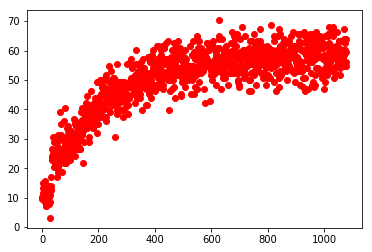

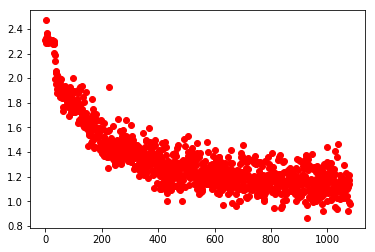

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

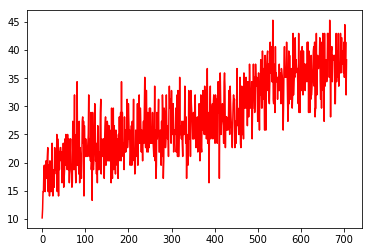

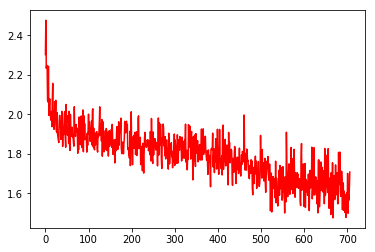

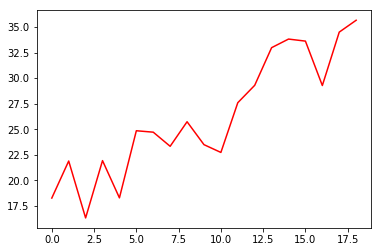

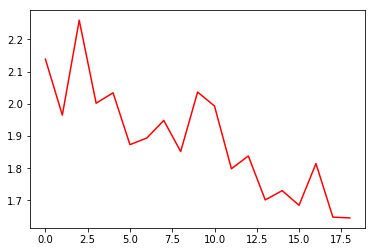

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()